<a href="https://colab.research.google.com/github/aruaru0/pytorch-tests/blob/main/Cleanlab_test_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cleanlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.3/352.3 kB 5.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

# 簡単なCNNモデルをMNISTの手書き文字を使って学習させる

In [3]:
train_dataset = torchvision.datasets.MNIST(root="data",
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)
valid_dataset = torchvision.datasets.MNIST(root="data",
                                           train=False,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12532702.41it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 357696.46it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3093626.34it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 840489.22it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



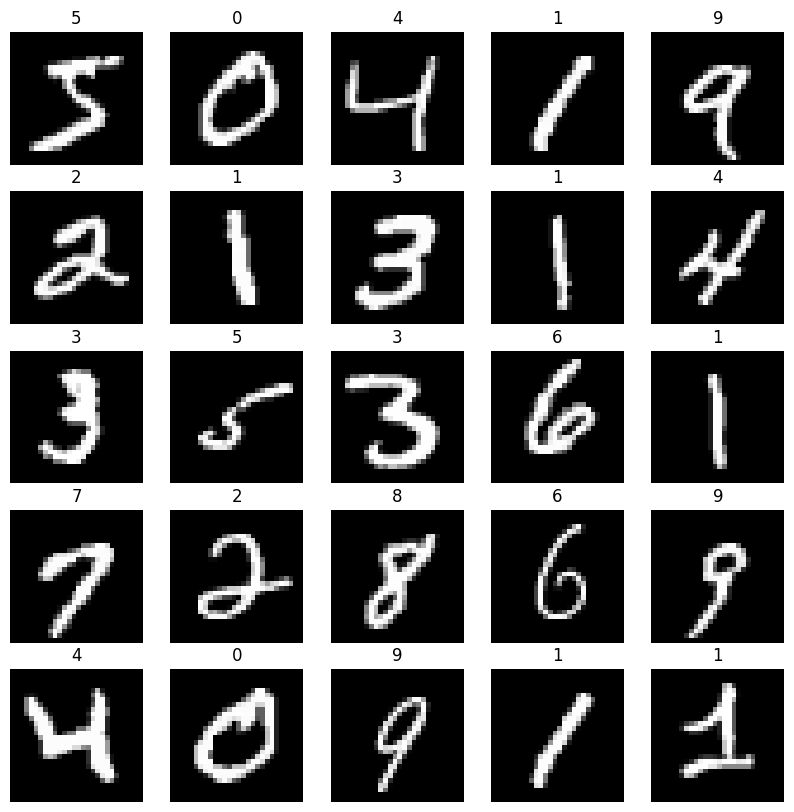

In [4]:
# データを確認
fig, ax = plt.subplots(5,5, figsize=(10,10))

for i in range(25) :
  img, label = train_dataset[i]
  r, c = i//5, i%5
  ax[r, c].imshow(img.squeeze(), cmap="gray")
  ax[r, c].axis("off")
  ax[r, c].set_title(label)

In [5]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class MyCNNModel(nn.Module):
  def __init__(self, input_size):
    super(MyCNNModel, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.act = nn.ReLU()
    self.pool2 = nn.AdaptiveAvgPool1d(1024)
    self.fc1 = nn.Linear(1024, 256)
    self.fc2 = nn.Linear(256, 10)
  def forward(self, x):
    x = self.pool(self.act(self.conv1(x)))
    x = self.pool(self.act(self.conv2(x)))
    x = torch.flatten(x, start_dim=1)
    x = self.pool2(x)
    x = self.act(self.fc1(x))
    x = self.fc2(x)
    return x


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyCNNModel(28).to(device)
model

MyCNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act): ReLU()
  (pool2): AdaptiveAvgPool1d(output_size=1024)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def do_train(model, device, loader, criterion, optimizer):
  model.train()
  tot_loss = 0.0
  tot_score = 0.0
  for images, labels in tqdm(loader, desc="train"):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    tot_loss += loss.detach().item()
    tot_score += accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())

  tot_loss /= len(loader)
  tot_score /= len(loader)
  return tot_loss, tot_score

In [10]:
def do_valid(model, device, loader, criterion):
  model.eval()
  tot_loss = 0.0
  tot_score = 0.0
  with torch.no_grad():
    for images, labels in tqdm(loader, desc="valid"):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      tot_loss += loss.detach().item()
      tot_score += accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())
  tot_loss /= len(loader)
  tot_score /= len(loader)
  return tot_loss, tot_score

In [11]:
num_epochs = 10
for epoch in range(num_epochs):
  print(f'[EPOCH {epoch+1}]')
  train_loss, train_acc = do_train(model, device, train_loader, criterion, optimizer)
  valid_loss, valid_acc = do_valid(model, device, valid_loader, criterion)
  print(f"--> train loss {train_loss}, train accuracy {train_acc}, valid loss {valid_loss} valid accuracy {valid_acc}")

[EPOCH 1]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.2572855822869074, train accuracy 0.9225079957356077, valid loss 0.10898500774648918 valid accuracy 0.9666600318471338
[EPOCH 2]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.0725238826073734, train accuracy 0.9779784115138592, valid loss 0.04799637057822921 valid accuracy 0.9842754777070064
[EPOCH 3]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.05086647779102435, train accuracy 0.9837253464818764, valid loss 0.04212229931180196 valid accuracy 0.9861664012738853
[EPOCH 4]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.039301757161979124, train accuracy 0.9877731876332623, valid loss 0.03527850460397913 valid accuracy 0.9886544585987261
[EPOCH 5]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.03231677247585157, train accuracy 0.9899886727078892, valid loss 0.0362670807980107 valid accuracy 0.9875597133757962
[EPOCH 6]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.025269415834161545, train accuracy 0.9920875533049041, valid loss 0.02553272448395042 valid accuracy 0.991640127388535
[EPOCH 7]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.02089767178359155, train accuracy 0.9931036780383795, valid loss 0.03241900624124743 valid accuracy 0.9902468152866242
[EPOCH 8]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.01819298251229329, train accuracy 0.9938865938166311, valid loss 0.03226128470009971 valid accuracy 0.9898487261146497
[EPOCH 9]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.014482173714824156, train accuracy 0.9954191098081023, valid loss 0.0326458047199542 valid accuracy 0.9899482484076433
[EPOCH 10]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.012709666998842349, train accuracy 0.9955023987206824, valid loss 0.02778747499492693 valid accuracy 0.9914410828025477


# cleanlabでtrainデータからノイズ画像を検出


In [12]:
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)


model.eval()
y_pred = []
y_gt = []
y_outputs = None
for batch in tqdm(test_loader):
    inputs, targets = batch
    with torch.no_grad() :
      outputs = model(inputs.to(device))
    y_gt += targets.tolist()
    y_pred += outputs.argmax(axis=1).tolist()
    if y_outputs is None:
      y_outputs = outputs.detach().cpu().softmax(dim=1).numpy()
    else:
      y_outputs = np.vstack((y_outputs, outputs.detach().cpu().softmax(dim=1).numpy()))

  0%|          | 0/938 [00:00<?, ?it/s]

In [13]:
import cleanlab
from cleanlab.filter import find_label_issues

# valid = find_label_issues(y_gt, y_outputs, filter_by="confident_learning")

print(f"正解と異なる推論データは{sum([1 if x != y else 0 for x, y in zip(y_gt, y_pred)])}個です")
valid = find_label_issues(y_gt, y_outputs, filter_by="predicted_neq_given")
print(f"predicted_neq_givenモードでノイズ画像を{sum(valid)}個発見しました")

valid = find_label_issues(y_gt, y_outputs, filter_by="prune_by_noise_rate")
print(f"prune_by_noise_rateモードでノイズ画像を{sum(valid)}個発見しました")

正解と異なる推論データは215個です
predicted_neq_givenモードでノイズ画像を215個発見しました
prune_by_noise_rateモードでノイズ画像を3個発見しました


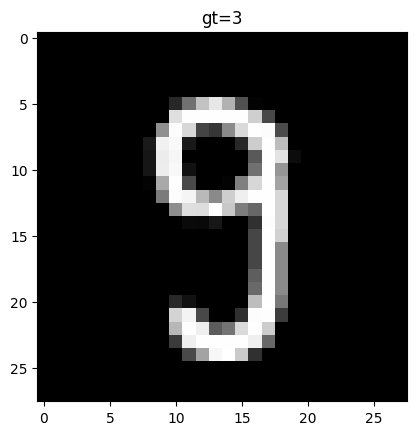

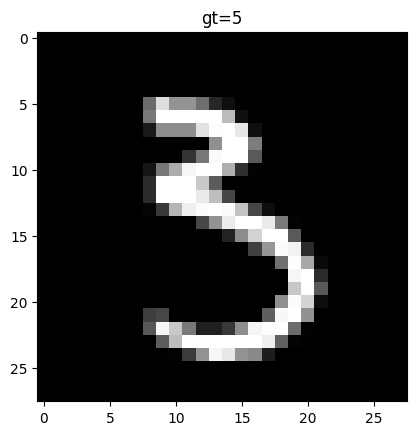

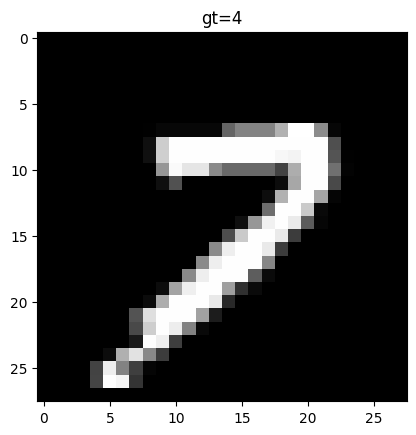

In [14]:
for idx, (gt, flg) in enumerate(zip(y_gt, valid)):
  if flg == True :
    img, label = train_dataset[idx]
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"gt={gt}")
    plt.show()